In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random
%matplotlib inline

In [2]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype
# X: From 5 words we have a dataset of 32 examples. Each example has size 3 because thats how much back we want to
# go on the word for training (integers corresponding to characters)
# Y: same as X but with one single prediction of the character coming next (integer)

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27, 2))
# The embeddings of each of these integers (characters) into the nn is done by vectors of dimension 2
# This is a weight matrix!

In [8]:
# A simple way to embed the character 'e' (integer 5) would simply be
C[5]

tensor([ 0.8450, -1.3980])

In [9]:
# We could also use the one hot encoding
F.one_hot(torch.tensor(5), num_classes=27).float() @ C #must input torch tensor! careful with datatypes!

tensor([ 0.8450, -1.3980])

In [10]:
# We will jsut use the first option in this case sice we can index with lists and tensors
C[[4,5,6]]

tensor([[ 0.1066,  0.9200],
        [ 0.8450, -1.3980],
        [ 1.8850,  0.4339]])

In [11]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
# -------------------------------------------------------------------------------------

In [13]:
# We construct the hidden layer, with number of inputs 3*2 = 6 and neurons 100 (free of choice)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [14]:
# Before multiplying we need to unstack the emb tensor to (something, 6) instead of (something, 3, 2)
# We want to concatenate the embedding of the three integers alltogether:
torch.cat((emb[:,0,:], emb[:,1,:], emb[:,2,:]), 1)

tensor([[-0.8687, -0.2353, -0.8687, -0.2353, -0.8687, -0.2353],
        [-0.8687, -0.2353, -0.8687, -0.2353,  0.8450, -1.3980],
        [-0.8687, -0.2353,  0.8450, -1.3980, -0.6180,  2.6447],
        ...,
        [ 0.9843,  0.3788,  0.9843,  0.3788, -1.4506, -0.7092],
        [ 0.9843,  0.3788, -1.4506, -0.7092,  0.9843,  0.3788],
        [-1.4506, -0.7092,  0.9843,  0.3788, -0.7466, -1.9923]])

In [15]:
# For general block size
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.8687, -0.2353, -0.8687, -0.2353, -0.8687, -0.2353],
        [-0.8687, -0.2353, -0.8687, -0.2353,  0.8450, -1.3980],
        [-0.8687, -0.2353,  0.8450, -1.3980, -0.6180,  2.6447],
        ...,
        [ 0.9843,  0.3788,  0.9843,  0.3788, -1.4506, -0.7092],
        [ 0.9843,  0.3788, -1.4506, -0.7092,  0.9843,  0.3788],
        [-1.4506, -0.7092,  0.9843,  0.3788, -0.7466, -1.9923]])

In [17]:
# However there is a better and more efficiient way of doing these operations
#emb.view(32, 6) # only works taking the first 5 names (32 examples)

In [19]:
# Therefore
#h = emb.view(32, 6) @ W1 + b1 # only works taking the first 5 names (32 examples)

In [20]:
# In geenral we can do
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [21]:
h

tensor([[ 0.0106, -0.8793,  0.1586,  ...,  0.9779,  0.8476,  0.9577],
        [-0.7428, -0.4157, -0.9799,  ...,  0.1043, -0.8140,  0.9801],
        [ 0.9986,  0.9650,  0.9916,  ...,  0.9986,  0.9999, -0.9910],
        ...,
        [ 0.3208,  0.9998,  0.7080,  ...,  0.1467,  0.9727,  0.9996],
        [ 0.9933, -0.9261,  0.2609,  ..., -0.9775,  0.8978,  0.8082],
        [-0.9978,  0.9994, -0.9260,  ...,  0.9945, -0.5496,  0.9980]])

In [22]:
W2 = torch.randn((100, 27)) # From 100 inputs to 27 outputs (neurons) -> the number of integers (letters)
b2 = torch.randn(27)

In [23]:
logits = h @ W2 + b2 # Outputs in the shape of one hot encoded integers for all the input integers: (something, 27)

In [24]:
counts = logits.exp()

In [25]:
prob = counts / counts.sum(1, keepdims = True)

In [26]:
# We can see that all rows (single letter belonging to somehting, probabilities of being any of the 27 letters) sum to 1
prob[0].sum()

tensor(1.)

In [27]:
# -------------------------------------------------------------------------------------

In [29]:
# Now we want to compare each of the outputs to the actual output that should be predicted given bt Y (to train)
#a = prob[torch.arange(32), Y] # probas of having predicted the next characted succesfully for our 32 examples, corresponding, only works taking the first 5 names (32 examples)
# to the 5 first words in words

In [31]:
# We need to do the minimization of the loss
#loss = -a.log().mean() # only works taking the first 5 names (32 examples)

In [33]:
#loss # only works taking the first 5 names (32 examples)

In [49]:
# Cleaning everything and puting it alltogether
# X, Y dataset already built (with 5 words to make it fast maybe)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [50]:
for p in parameters:
    p.requires_grad = True

In [51]:
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #prob = counts / counts.sum(1, keepdims = True)
    #a = prob[torch.arange(32), Y]
    #loss = -a.log().mean()
    loss = F.cross_entropy(logits, Y) # does the same as the three commented lines above
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad

19.505229949951172
17.084487915039062
15.776531219482422
14.833340644836426
14.002598762512207
13.253256797790527
12.579916954040527
11.983099937438965
11.47049331665039
11.051857948303223


In [52]:
# -------------------------------------------------------------------------------------

In [53]:
# We see that it takes long, so we may want to just train with batches instead of the whole dataset
# To create random numbers between 0 and the total number of examples we do
torch.randint(0, X.shape[0], (32,))

tensor([194384,  93484,  67450, 138998, 148686, 225083, 118170, 150704, 102887,
        118619,  56915, 138585,  46111,  38285, 187918,  26328, 214203, 174070,
         81773, 103300,  61407,  63040, 165479, 168270, 138763, 183782, 193212,
         30651,  65992, 199997,  10243, 167088])

In [54]:
for _ in range(100):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #prob = counts / counts.sum(1, keepdims = True)
    #a = prob[torch.arange(32), Y]
    #loss = -a.log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # does the same as the three commented lines above
    
    #backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad

print(loss.item())

4.040523529052734


In [55]:
# To better determine the learning rate we do this
lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre
#lrs

In [56]:
lri = []
lossi = []

for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #prob = counts / counts.sum(1, keepdims = True)
    #a = prob[torch.arange(32), Y]
    #loss = -a.log().mean()
    
    loss = F.cross_entropy(logits, Y[ix]) # does the same as the three commented lines above
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    #lr = lrs[i]
    lr = 10**(-1)
    
    loss.backward()
    #update
    for p in parameters:
        p.data += -lr * p.grad
    
    #tracking
    lri.append(lre[i]) # we store the exponent of the learning rate
    lossi.append(loss.item())

print(loss.item())

2.723832607269287


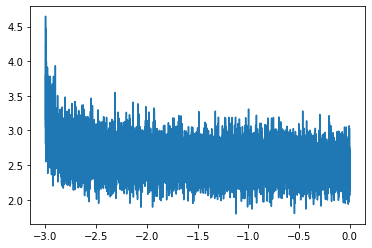

In [57]:
plt.plot(lri, lossi)

In [58]:
# -------------------------------------------------------------------------------------

In [59]:
# If we train and train the model we will run into overfitting problem
# In order to avoid this we split the data set into: training, dev/validation (for hyperparameter training such as
# the number of neurones) and test split - 80, 10 and 10 % respectively

# build the dataset splitted
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # Now this is the dataset for training
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [60]:
# Our dataset for training
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [61]:
lri = []
lossi = []
stepi = []

for i in range(100):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #prob = counts / counts.sum(1, keepdims = True)
    #a = prob[torch.arange(32), Y]
    #loss = -a.log().mean()
    
    loss = F.cross_entropy(logits, Ytr[ix]) # does the same as the three commented lines above
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    #lr = lrs[i]
    lr = 10**(-1)
    
    loss.backward()
    #update
    for p in parameters:
        p.data += -lr * p.grad
    
    #tracking
    lri.append(lre[i]) # we store the exponent of the learning rate
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())

2.0498671531677246


In [62]:
# But now we evaluate the loss with the other dataset
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4772, grad_fn=<NllLossBackward0>)

In [63]:
# We compare it with the loss on the whole trianing dataset
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4825, grad_fn=<NllLossBackward0>)

In [64]:
# Since the loss in the evaluation is roughly equal to the training we are not overfitting
# However it also means that we are underfitting and that the size of our nn is not the optimal, it is smaller
# Let's do this

In [65]:
# -------------------------------------------------------------------------------------

In [66]:
# Cleaning everything and puting it alltogether
# X, Y dataset already built (with 5 words to make it fast maybe)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [67]:
for p in parameters:
    p.requires_grad = True

In [68]:
for i in range(40000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #prob = counts / counts.sum(1, keepdims = True)
    #a = prob[torch.arange(32), Y]
    #loss = -a.log().mean()
    
    loss = F.cross_entropy(logits, Ytr[ix]) # does the same as the three commented lines above
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    #lr = lrs[i]
    lr = 10**(-2)
    
    loss.backward()
    #update
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.609015464782715


In [69]:
# But now we evaluate the loss with the other dataset
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4701, grad_fn=<NllLossBackward0>)

In [70]:
# We compare it with the loss on the whole trianing dataset
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4730, grad_fn=<NllLossBackward0>)

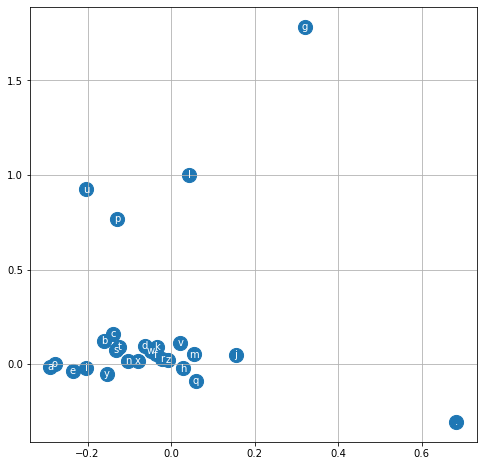

In [71]:
# While we are in 2 dimensional embeddings of the characters we may want to visualize them
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [72]:
# We increase the number of embeddings
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [73]:
for p in parameters:
    p.requires_grad = True

In [74]:
lri = []
lossi = []
stepi = []

In [75]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # Avoid hardcoding these numbers like 30!
    logits = h @ W2 + b2
    #prob = counts / counts.sum(1, keepdims = True)
    #a = prob[torch.arange(32), Y]
    #loss = -a.log().mean()
    
    loss = F.cross_entropy(logits, Ytr[ix]) # does the same as the three commented lines above
    
    #backward pass
    for p in parameters:
        p.grad = None
    
    #lr = lrs[i]
    lr = 10**(-2)
    
    loss.backward()
    #update
    for p in parameters:
        p.data += -lr * p.grad
    
    #tracking
    lossi.append(loss.log10().item())
    stepi.append(i)


print(loss.item())

2.043778657913208


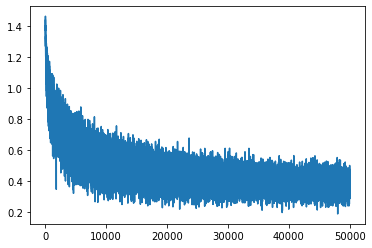

In [76]:
# We plot the log of loss vs the step
plt.plot(stepi, lossi)

In [77]:
# But now we evaluate the loss with the other dataset
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # challenge: surpas (go lower than) 2.1701
loss

tensor(2.3969, grad_fn=<NllLossBackward0>)

In [78]:
# We compare it with the loss on the whole trianing dataset
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3937, grad_fn=<NllLossBackward0>)

In [84]:
# Running a first iteration with learning rate 0.1 and some other 0.01 we start to see that the
# loss on the training set is lower than the one in the evaluation set, sign of possible slight overfitting

In [88]:
# finally a taste of how to sample from the model :)
#g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

pordi.
fen.
meoe.
gavei.
joreney.
hen.
reo.
jis.
siri.
evonywalle.
